In [1]:
import os
import torch
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from time import time as time

from sklearn.metrics import confusion_matrix
import torchnet as tnt
import functools

import mock
from tqdm import tqdm_notebook as tqdm


# GLOBAL SETTINGS
PlotSize = 12                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = matplotlib.colors.ListedColormap(['black', 'white', 'orange'])               # Color mapping 
np.set_printoptions(precision=2, suppress=True)  # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names = ['BACKGRD','PINUS','PICEA']

# PATHS TO TRAIN/TEST DATA
data_path = '../data/split_05__05_512/'
training_set_path = data_path + 'train/'         # Relative path to training patch root folder
test_set_path =     data_path + 'test/'          # Relative path to test patch root folder

num_of_training_tiles = len(os.listdir(training_set_path + 'GT/'))
num_of_test_tiles = len(os.listdir(test_set_path + 'GT/'))

# USE CIR OR RGB DATA
use_cir = False
use_rgb = True

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

In [2]:
def read_patch(root_folder, cir=True, rgb=True):
    ##########################################################
    # READ IMAGES as FLOAT
    
    if cir:
        cir_file_list = os.listdir(root_folder + 'CIR/')
        cir_list = []
        
        for file in cir_file_list:
            cir_patch = imageio.imread(root_folder + 'CIR/' + file).astype(np.float32)
            cir_patch = cir_patch[:,:,:].transpose([2,0,1])
            cir_patch = cir_patch * 1/255
            
            cir_list.append(cir_patch)
            del cir_patch

        cir_features = np.stack(cir_list, axis=0)
    
    
    if rgb:
        rgb_file_list = os.listdir(root_folder + 'RGB/')
        rgb_list = []
        
        for file in rgb_file_list:
            rgb_patch = imageio.imread(root_folder + 'RGB/' + file).astype(np.float32)
            rgb_patch = rgb_patch[:,:,:].transpose([2,0,1])
            rgb_patch = rgb_patch * 1/255
            
            rgb_list.append(rgb_patch)
            
            del rgb_patch
        
        rgb_features = np.stack(rgb_list, axis=0)


    gt_file_list = os.listdir(root_folder + 'GT/')
    gt_list = []

    for file in gt_file_list:
        gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.int64)
 
        gt_list.append(gt_patch[:,:])
        del gt_patch

    
    if cir and rgb:
        features = np.concatenate([cir_features, rgb_features], axis=1)
    elif cir:
        features = cir_features
    elif rgb:
        features = rgb_features
    else:
        print('No valid data input.')
    
    ground_truth = np.stack(gt_list, axis=0)

    features = torch.from_numpy(features)
    #features = features.cuda()
    ground_truth = torch.from_numpy(ground_truth)
    
    ########################################################## 
    return features, ground_truth

In [3]:
#putting the dataset into the TensorDataset wrapper
X, y = read_patch(training_set_path, use_cir, use_rgb)
X_t, y_t = read_patch(test_set_path, use_cir, use_rgb)

print(X.shape)
print(X_t.shape)


train_set = tnt.dataset.TensorDataset(list([X, y]))
test_set  = tnt.dataset.TensorDataset(list([X_t, y_t]))
print(len(train_set))

torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
20


In [4]:
class ConfusionMatrix:
    def __init__(self, n_class, class_names):
        self.CM = np.zeros((n_class, n_class))
        self.n_class = n_class
        self.class_names = class_names
  
    def clear(self):
        self.CM = np.zeros((self.n_class, self.n_class))
    
    def add_batch(self, gt, pred):
        self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
    def overall_accuracy(self):#percentage of correct classification
        return 100*self.CM.trace() / self.CM.sum()

    def class_IoU(self, show = 1):
        ious = np.full(self.n_class, 0.)
        for i_class in range(self.n_class):
            ious[i_class] = self.CM[i_class, i_class] / \
                (-self.CM[i_class, i_class] \
                + self.CM[i_class, :].sum()
                + self.CM[:, i_class].sum())
        if show:
            print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
        #do not count classes that are not present in the dataset in the mean IoU
        return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [ ]:
m = ConfusionMatrix(3, class_names)
m.add_batch(np.array([0,1,1,1,2,0,0,2,0,2,1]), np.array([0,1,0,0,2,0,1,2,0,2,1]))
m.add_batch(np.array([0,1,2,1,2,1,0,2,1]), np.array([0,1,1,1,2,1,0,2,0]))
print(m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()
m.clear()

In [5]:
class UNet(nn.Module):
    """
    U-Net network for semantic segmentation
    """
  
    def __init__(self, n_channels, encoder_conv_width, decoder_conv_width, n_class, cuda = False):
        """
        initialization function
        n_channels, int, number of input channel
        encoder_conv_width, int list, size of the feature maps of convs for the encoder
        decoder_conv_width, int list, size of the feature maps of convs for the decoder
        n_class = int,  the number of classes
        """
        super(UNet, self).__init__() #necessary for all classes extending the module class
    
        self.maxpool=nn.MaxPool2d(2,2,return_indices=False) #maxpooling layer
    
        #encoder
        self.c1 = nn.Sequential(nn.Conv2d(n_channels,encoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c2 = nn.Sequential(nn.Conv2d(encoder_conv_width[0],encoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c3 = nn.Sequential(nn.Conv2d(encoder_conv_width[1],encoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c4 = nn.Sequential(nn.Conv2d(encoder_conv_width[2],encoder_conv_width[3],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c5 = nn.Sequential(nn.Conv2d(encoder_conv_width[3],encoder_conv_width[4],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c6 = nn.Sequential(nn.Conv2d(encoder_conv_width[4],encoder_conv_width[5],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c7 = nn.Sequential(nn.Conv2d(encoder_conv_width[5],encoder_conv_width[6],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c8 = nn.Sequential(nn.Conv2d(encoder_conv_width[6],encoder_conv_width[7],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c9 = nn.Sequential(nn.Conv2d(encoder_conv_width[7],encoder_conv_width[8],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c10 = nn.Sequential(nn.Conv2d(encoder_conv_width[8],encoder_conv_width[9],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        #decoder
        self.c11 = nn.ConvTranspose2d(encoder_conv_width[9], int(decoder_conv_width[0]/2),kernel_size=2, stride=2)
        self.c12 = nn.Sequential(nn.Conv2d(decoder_conv_width[0],decoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c13 = nn.Sequential(nn.Conv2d(decoder_conv_width[1],decoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c14 = nn.ConvTranspose2d(decoder_conv_width[2], int(decoder_conv_width[3]/2),kernel_size=2, stride=2)
        self.c15 = nn.Sequential(nn.Conv2d(decoder_conv_width[3],decoder_conv_width[4],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c16 = nn.Sequential(nn.Conv2d(decoder_conv_width[4],decoder_conv_width[5],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c17 = nn.ConvTranspose2d(decoder_conv_width[5], int(decoder_conv_width[6]/2),kernel_size=2, stride=2)
        self.c18 = nn.Sequential(nn.Conv2d(decoder_conv_width[6],decoder_conv_width[7],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c19 = nn.Sequential(nn.Conv2d(decoder_conv_width[7],decoder_conv_width[8],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c20 = nn.ConvTranspose2d(decoder_conv_width[8], int(decoder_conv_width[9]/2),kernel_size=2, stride=2)
        self.c21 = nn.Sequential(nn.Conv2d(decoder_conv_width[9],decoder_conv_width[10],3,padding=1, padding_mode='reflect'),nn.ReLU(True))
        self.c22 = nn.Sequential(nn.Conv2d(decoder_conv_width[10],decoder_conv_width[11],3,padding=1, padding_mode='reflect'),nn.ReLU(True)) 
        
        #final classifying layer
        self.classifier=nn.Conv2d(decoder_conv_width[11],n_class,1,padding=0)

        #weight initialization

        self.c1[0].apply(self.init_weights)
        self.c2[0].apply(self.init_weights)
        self.c3[0].apply(self.init_weights)
        self.c4[0].apply(self.init_weights)
        self.c5[0].apply(self.init_weights)
        self.c6[0].apply(self.init_weights)
        self.c7[0].apply(self.init_weights)
        self.c8[0].apply(self.init_weights)
        self.c9[0].apply(self.init_weights)
        self.c10[0].apply(self.init_weights)
        
        self.c12[0].apply(self.init_weights)
        self.c13[0].apply(self.init_weights)
        
        self.c15[0].apply(self.init_weights)
        self.c16[0].apply(self.init_weights)
        
        self.c18[0].apply(self.init_weights)
        self.c19[0].apply(self.init_weights)
        
        self.c21[0].apply(self.init_weights)
        self.c22[0].apply(self.init_weights)
        self.classifier.apply(self.init_weights)
    
        if cuda: #put the model on the GPU memory
            self.cuda()
    
    def init_weights(self,layer): #gaussian init for the conv layers
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self,input):
        """
        the function called to run inference
        """  
        #encoder
        #level 1
        x1 = self.c2(self.c1(input))
        x2 = self.maxpool(x1)
        #level 2
        x3 = self.c4(self.c3(x2))
        x4 = self.maxpool(x3)
        #level 3
        x5 = self.c6(self.c5(x4))
        x6 = self.maxpool(x5)
        #Level 4
        x7 = self.c8(self.c7(x6))
        x8 = self.maxpool(x7)
        #Level 5
        x9 = self.c10(self.c9(x8))
        #decoder
        #Level 4
        y8 = torch.cat((self.c11(x9),x7),1)
        y7 = self.c13(self.c12(y8))
        #Level 3
        y6 = torch.cat((self.c14(y7),x5),1)
        y5 = self.c16(self.c15(y6))
        #level 2
        y4 = torch.cat((self.c17(y5),x3),1)
        y3 = self.c19(self.c18(y4))
        #level 1       
        y2 = torch.cat((self.c20(y3),x1),1)
        y1 = self.c22(self.c21(y2))
        #output         
        out = self.classifier(y1)
    
        return out

In [6]:
def train(model, optimizer, args):
  """train for one epoch"""
  model.train() #switch the model in training mode
  
  #the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for index, (tiles, gt) in enumerate(loader):
    
    optimizer.zero_grad() #put gradient to zero
    
    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred.cpu(),gt, weight=torch.tensor(args.class_weights))

    loss.backward() #compute gradients

    for p in model.parameters(): #we clip the gradient at norm 1
      p.grad.data.clamp_(-1, 1) #this helps learning faster
    
    optimizer.step() #one SGD step
    
    loss_meter.add(loss.item())
    labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
    #need to put the prediction back on the cpu and convert to numpy
    cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())
    
  return cm, loss_meter.value()[0]

def eval(model, args):
  """eval on test/validation set"""
  
  model.eval() #switch in eval mode
  
  loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  
  loader = tqdm(loader, ncols=500)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad():
    for index, (tiles, gt) in enumerate(loader):
      
      #TODO
      pred = model(tiles)
      loss = nn.functional.cross_entropy(pred.cpu(),gt)
      loss_meter.add(loss.item())
      labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
      cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())

  return cm, loss_meter.value()[0]


def train_full(args):
  """The full training loop"""
  #initialize the model
  
  model = UNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
  #define the optimizer
  #adam optimizer is always a good guess for classification
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,90], gamma=0.7)
  
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'
  
  training_accu=[]
  training_miou=[]
  training_loss=[]
  training_epoch=[]
  test_accu=[]
  test_miou=[]
  test_loss=[]
  test_epoch=[]

  for i_epoch in range(args.n_epoch):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, args)
    scheduler.step()
    print(TRAINCOLOR)
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)
    training_epoch.append(i_epoch)
    training_accu.append(cm_train.overall_accuracy())
    training_miou.append(cm_train.class_IoU())
    training_loss.append(loss_train)

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #periodic testing
      cm_test, loss_test = eval(model, args)
      print(TESTCOLOR)
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
      test_epoch.append(i_epoch)
      test_accu.append(cm_test.overall_accuracy())
      test_miou.append(cm_test.class_IoU())
      test_loss.append(loss_test)
      #viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)

  plt.figure(figsize=(30, 10))
  plt.subplot(1,3,1, ylim=(0,100), xlabel="# of epochs", ylabel="Overall Accuracy")
  plt.plot(training_epoch, training_accu)
  plt.plot(test_epoch, test_accu)
  plt.subplot(1,3,2, ylim=(0,100), xlabel="# of epochs", ylabel="mean Class IoU")
  plt.plot(training_epoch, training_miou)
  plt.plot(test_epoch, test_miou)
  plt.subplot(1,3,3, ylim=(0,1), xlabel="# of epochs", ylabel="Loss function")
  plt.plot(training_epoch, training_loss)
  plt.plot(test_epoch, test_loss)
  plt.show()
  return model

In [ ]:
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 4
args.n_class = len(class_names)
args.n_channel = 6 if use_cir and use_rgb else 3
args.conv_width = [64,64,128,128,256,256,512,512,1024,1024]
args.dconv_width = [1024,512,512,512,256,256,256,128,128,128,64,64]
args.class_weights = torch.tensor([0.15, 0.15, 0.7])
args.cuda = 0
args.lr = 5e-4

a = time()
trained_model = train_full(args)
b = time()

print('Training finished in ' + str(b-a) + 's')

In [ ]:
def train(model, optimizer, args):
    """train for one epoch"""
    model.train() #switch the model in training mode
  
    #the loader function will take care of the batching
    loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  
    #will keep track of the loss
    loss_meter = tnt.meter.AverageValueMeter()

    for index, (tiles, gt) in enumerate(loader):
    
        optimizer.zero_grad() #put gradient to zero
    
        pred = model(tiles) #compute the prediction

        loss = nn.functional.cross_entropy(pred.cpu(),gt)

        loss.backward() #compute gradients

        for p in model.parameters(): #we clip the gradient at norm 1
            p.grad.data.clamp_(-1, 1) #this helps learning faster
    
        optimizer.step() #one SGD step
    
        loss_meter.add(loss.item())
    
    return loss_meter.value()[0]

def eval(model, args):
    """eval on test/validation set"""
  
    model.eval() #switch in eval mode
  
    loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  
    loader = tqdm(loader, ncols=500)
  
    loss_meter = tnt.meter.AverageValueMeter()
    cm = ConfusionMatrix(args.n_class, class_names = class_names)

    with torch.no_grad():
        for index, (tiles, gt) in enumerate(loader):
      
        #TODO
        pred = model(tiles)
        loss = nn.functional.cross_entropy(pred.cpu(),gt)
        loss_meter.add(loss.item())
        labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
        cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())

    return cm, loss_meter.value()[0]


def train_full(args):
    """The full training loop"""

    #initialize the model
    model = UNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)

    print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
    #define the optimizer
    #adam optimizer is always a good guess for classification
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,90], gamma=0.7)
  
    TESTCOLOR = '\033[104m'
    NORMALCOLOR = '\033[0m'
  
    test_accu=[]
    test_miou=[]
    test_loss=[]
    test_epoch=[]

    for i_epoch in range(args.n_epoch):
        #train one epoch
        loss_train = train(model, optimizer, args)
        scheduler.step()

        if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
            #periodic testing
            cm_test, loss_test = eval(model, args)
            print(TESTCOLOR)
            print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
            test_epoch.append(i_epoch)
            test_accu.append(cm_test.overall_accuracy())
            test_miou.append(cm_test.class_IoU())
            test_loss.append(loss_test)

    plt.figure(figsize=(30, 10))
    plt.subplot(1,3,1, ylim=(0,100), xlabel="# of epochs", ylabel="Overall Accuracy")
    plt.plot(test_epoch, test_accu)
    plt.subplot(1,3,2, ylim=(0,100), xlabel="# of epochs", ylabel="mean Class IoU")
    plt.plot(test_epoch, test_miou)
    plt.subplot(1,3,3, ylim=(0,1), xlabel="# of epochs", ylabel="Loss function")
    plt.plot(test_epoch, test_loss)
    plt.show()
    return model

In [ ]:
print(X_t.shape)
print(y_t.shape)

print(X_t.max())
print(X_t.min())
print(y_t.max())
print(y_t.min())

In [7]:
def plot_rgb_cir_gt_pred(tile_index, data, gt, model, cir, rgb):
    # Function to plot prediction vs ground truth
    
    # Plotting
    plt.figure(facecolor='white')

    data = data[tile_index,:,:,:]
    pred = model(data[None,:,:,:]).cpu().detach().numpy()
    pred = pred[0,:,:,:].argmax(0).squeeze()
    
    unique, counts = np.unique(pred, return_counts=True)
    print(dict(zip(unique, counts)))
    
    data = data.cpu().numpy()
    
    if cir and rgb:
        plt.subplot(1, 4, 1)
        plt.imshow(data[:3].transpose([1,2,0]))
        plt.title('NIR Red Green composite')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(data[-3:].transpose([1,2,0]))
        plt.title('Red Green Blue composite')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')
    
    elif cir or rgb:
        plt.subplot(1, 3, 1)
        plt.imshow(data.transpose([1,2,0]))
        if cir:
            plt.title('NIR Red Green composite')
        else:
            plt.title('Red Green Blue composite')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')

In [ ]:
plot_rgb_cir_gt_pred(8, X_t, y_t, trained_model, use_cir, use_rgb)

In [ ]:
cm, loss = eval(trained_model)

## Saving and reusing a trained model

In [8]:
# Path to the state_dictionary
state_dict_path = 'trained_models/U_Net_fromScratch_rgb.pt'

Save a model to state_dict_path:

In [ ]:
# Save a trained model state_dictionary
torch.save(trained_model.state_dict(), state_dict_path)

Reuse a model at state_dict_path:

In [9]:
# Parameters for model definition
args = mock.Mock() #stores the parameters

args.n_class = len(class_names)
args.n_channel = 6 if use_cir and use_rgb else 3
args.conv_width = [64,64,128,128,256,256,512,512,1024,1024]
args.dconv_width = [1024,512,512,512,256,256,256,128,128,128,64,64]

In [10]:
# Load a trained model state_dictionary
model = UNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)
model.load_state_dict(torch.load(state_dict_path))
model.eval()

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (c7)

{0: 131930, 1: 100380, 2: 29834}


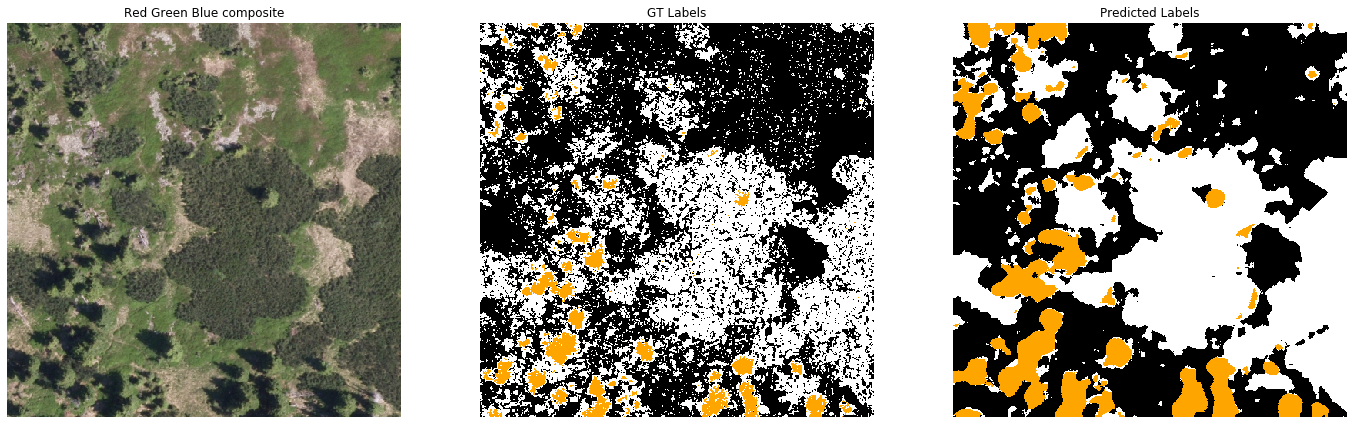

In [11]:
plot_rgb_cir_gt_pred(8, X_t, y_t, model, use_cir, use_rgb)

In [ ]:
cm, loss = eval(model, args)

In [ ]:
cm.overall_accuracy()
cm.class_IoU()

## Export and results
They are not georeferenced - use ArcPy_georeference_results.py for georeferencing and combining into a single raster

In [13]:
from distutils.dir_util import copy_tree


source_path = '../data/split_05__05_512/test/'
results_path = '../data/results/rgbUnet/'

In [14]:
in_features, ground_truth = read_patch(source_path, use_cir, use_rgb)

In [ ]:
data = data[tile_index,:,:,:]
pred = model(data[None,:,:,:]).cpu().detach().numpy()
pred = pred[0,:,:,:].argmax(0).squeeze()
data = data.cpu().numpy()

gt_file_list = os.listdir(root_folder + 'GT/')
    gt_list = []

    for file in gt_file_list:
        gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.int64)
 
        gt_list.append(gt_patch[:,:])
        del gt_patch

In [15]:
print(in_features.shape)
print(ground_truth.shape)

torch.Size([20, 3, 512, 512])
torch.Size([20, 512, 512])


In [17]:
copy_tree(source_path + 'GT/', results_path, update=1)

['../data/results/rgbUnet/GT_28_30.tif',
 '../data/results/rgbUnet/GT_28_31.tif',
 '../data/results/rgbUnet/GT_28_32.tif',
 '../data/results/rgbUnet/GT_28_33.tif',
 '../data/results/rgbUnet/GT_28_34.tif',
 '../data/results/rgbUnet/GT_28_35.tif',
 '../data/results/rgbUnet/GT_28_36.tif',
 '../data/results/rgbUnet/GT_28_37.tif',
 '../data/results/rgbUnet/GT_28_38.tif',
 '../data/results/rgbUnet/GT_28_39.tif',
 '../data/results/rgbUnet/GT_28_40.tif',
 '../data/results/rgbUnet/GT_28_41.tif',
 '../data/results/rgbUnet/GT_28_42.tif',
 '../data/results/rgbUnet/GT_28_43.tif',
 '../data/results/rgbUnet/GT_28_44.tif',
 '../data/results/rgbUnet/GT_28_45.tif',
 '../data/results/rgbUnet/GT_28_46.tif',
 '../data/results/rgbUnet/GT_28_47.tif',
 '../data/results/rgbUnet/GT_28_48.tif',
 '../data/results/rgbUnet/GT_28_49.tif']

In [22]:
i = 0
for patch in os.listdir(results_path):
    in_patch = in_features[i,:,:,:]
    pred = model(in_patch[None,:,:,:]).cpu().detach().numpy()
    pred = pred[0,:,:,:].argmax(0).squeeze()
    print(patch)
    print(pred.shape)
    imageio.imwrite(results_path + patch,pred.astype(np.uint8))
    
    #with rasterio.open(results_path+patch,'w') as dst:
    #    dst.write(pred, 1)
    i+=1

GT_28_30.tif
(512, 512)
GT_28_31.tif
(512, 512)
GT_28_32.tif
(512, 512)
GT_28_33.tif
(512, 512)
GT_28_34.tif
(512, 512)
GT_28_35.tif
(512, 512)
GT_28_36.tif
(512, 512)
GT_28_37.tif
(512, 512)
GT_28_38.tif
(512, 512)
GT_28_39.tif
(512, 512)
GT_28_40.tif
(512, 512)
GT_28_41.tif
(512, 512)
GT_28_42.tif
(512, 512)
GT_28_43.tif
(512, 512)
GT_28_44.tif
(512, 512)
GT_28_45.tif
(512, 512)
GT_28_46.tif
(512, 512)
GT_28_47.tif
(512, 512)
GT_28_48.tif
(512, 512)
GT_28_49.tif
(512, 512)
